### Model building - on Sensor data

In [2]:
## Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline

In [52]:
## Display settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [103]:
## Model building libraries
from sklearn.preprocessing import StandardScaler,MinMaxScaler,QuantileTransformer
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,confusion_matrix,roc_curve,auc
from sklearn.model_selection import train_test_split,cross_val_score,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [29]:
path1 = 'F:\\DATASCIENCE\\Acdgld_Sudhanshu\\AIforCV\Problem 3\\Training dataset.xlsx'
path2 = 'F:\\DATASCIENCE\\Acdgld_Sudhanshu\\AIforCV\Problem 3\\Training outputs.xlsx'
data_1 = pd.read_excel(path1)
data_2 = pd.read_excel(path2)
df = data_1.merge(data_2,left_index=True,right_index=True)
df.head()

,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-6,Sensor-7,Sensor-8,Sensor-9,Sensor-10,...,Sensor-582,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
Wafer-1,2988.30,2519.05,2208.8556,1157.7224,1.5509,100.0,107.8022,0.1233,1.5362,-0.0259,...,47.1586,0.5036,0.0169,0.0039,3.3514,0.0229,0.0108,0.0032,47.1586,-1
Wafer-2,2987.32,2528.81,NaN,NaN,NaN,NaN,NaN,0.1195,1.6343,-0.0263,...,NaN,0.5011,0.0117,0.0033,2.3308,0.0229,0.0108,0.0032,47.1586,-1
Wafer-3,NaN,2481.85,2207.3889,962.5317,1.2043,100.0,104.0311,0.1210,1.5559,0.0002,...,34.4153,0.4947,0.0137,0.0041,2.7729,0.0175,0.0060,0.0023,34.4153,-1
Wafer-4,3002.27,2497.45,2207.3889,962.5317,1.2043,100.0,104.0311,0.1210,1.5465,0.0195,...,114.5979,0.4977,0.0114,0.0037,2.2849,0.0250,0.0286,0.0075,114.5979,-1
Wafer-5,3010.41,2632.80,2203.9000,1116.4129,1.2639,100.0,102.2733,0.1199,1.4227,0.0194,...,125.0600,0.5032,0.0159,0.0039,3.1576,0.0288,0.0361,0.0101,125.0600,-1


In [60]:
data = df.copy()
data.shape

(1537, 591)

In [61]:
data['Good/Bad'].value_counts(dropna=False)

-1    1448
 1      89
Name: Good/Bad, dtype: int64

In [62]:
data.rename(columns={'Good/Bad':'target'},inplace=True)
data.target.replace({-1:0},inplace=True)
data.target.value_counts(dropna=False)

0    1448
1      89
Name: target, dtype: int64

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1537 entries, Wafer-1 to Wafer-1537
Columns: 591 entries, Sensor-1 to target
dtypes: float64(590), int64(1)
memory usage: 6.9+ MB


#### Remove columns with more thatn 50% missingness

In [64]:
threshold = int(0.50*data.shape[0])
data.dropna(thresh=threshold,axis=1,inplace=True)
print(data.shape)

(1537, 563)


#### Drop columns with constant value

In [65]:
nunique = data.apply(pd.Series.nunique)
drop_const_cols = nunique[nunique==1].index
data.drop(drop_const_cols,axis=1,inplace=True)
print(data.shape)

(1537, 447)


#### Find missingness and fill with mean value

In [56]:
(data.isnull().sum()/data.shape[0])*100

Sensor-1       0.390371
Sensor-2       0.455433
Sensor-3       0.910865
Sensor-4       0.910865
Sensor-5       0.910865
Sensor-7       0.910865
Sensor-8       0.585556
Sensor-9       0.130124
Sensor-10      0.130124
Sensor-11      0.130124
Sensor-12      0.130124
Sensor-13      0.130124
Sensor-15      0.195185
Sensor-16      0.195185
Sensor-17      0.195185
Sensor-18      0.195185
Sensor-19      0.195185
Sensor-20      0.585556
Sensor-21      0.000000
Sensor-22      0.130124
Sensor-23      0.130124
Sensor-24      0.130124
Sensor-25      0.130124
Sensor-26      0.130124
Sensor-27      0.130124
Sensor-28      0.130124
Sensor-29      0.130124
Sensor-30      0.130124
Sensor-31      0.130124
Sensor-32      0.130124
Sensor-33      0.065062
Sensor-34      0.065062
Sensor-35      0.065062
Sensor-36      0.065062
Sensor-37      0.065062
Sensor-38      0.065062
Sensor-39      0.065062
Sensor-40      0.065062
Sensor-41      1.561483
Sensor-42      1.561483
Sensor-44      0.065062
Sensor-45      0

In [66]:
## Fill missing value with mean
data.fillna(data.mean(),inplace=True)
(data.isnull().sum()/data.shape[0])*100

Sensor-1      0.0
Sensor-2      0.0
Sensor-3      0.0
Sensor-4      0.0
Sensor-5      0.0
Sensor-7      0.0
Sensor-8      0.0
Sensor-9      0.0
Sensor-10     0.0
Sensor-11     0.0
Sensor-12     0.0
Sensor-13     0.0
Sensor-15     0.0
Sensor-16     0.0
Sensor-17     0.0
Sensor-18     0.0
Sensor-19     0.0
Sensor-20     0.0
Sensor-21     0.0
Sensor-22     0.0
Sensor-23     0.0
Sensor-24     0.0
Sensor-25     0.0
Sensor-26     0.0
Sensor-27     0.0
Sensor-28     0.0
Sensor-29     0.0
Sensor-30     0.0
Sensor-31     0.0
Sensor-32     0.0
Sensor-33     0.0
Sensor-34     0.0
Sensor-35     0.0
Sensor-36     0.0
Sensor-37     0.0
Sensor-38     0.0
Sensor-39     0.0
Sensor-40     0.0
Sensor-41     0.0
Sensor-42     0.0
Sensor-44     0.0
Sensor-45     0.0
Sensor-46     0.0
Sensor-47     0.0
Sensor-48     0.0
Sensor-49     0.0
Sensor-51     0.0
Sensor-52     0.0
Sensor-54     0.0
Sensor-55     0.0
Sensor-56     0.0
Sensor-57     0.0
Sensor-58     0.0
Sensor-59     0.0
Sensor-60     0.0
Sensor-61 

#### The Data is imbalanced data  - 1: 6% , 0: 94%

In [68]:
data.target.value_counts(normalize=True)

0    0.942095
1    0.057905
Name: target, dtype: float64

#### Scale the data as it is in different units

In [88]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(data.iloc[:,:-1].values)
scaled_data_1 = pd.DataFrame(scaled_feat,index=data.iloc[:,:-1].index,columns=data.iloc[:,:-1].columns)
scaled_data = scaled_data_1.merge(pd.DataFrame(data.iloc[:,-1]),left_index=True,right_index=True)
scaled_data.head()

,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-7,Sensor-8,Sensor-9,Sensor-10,Sensor-11,Sensor-12,Sensor-13,Sensor-15,Sensor-16,Sensor-17,Sensor-18,Sensor-19,Sensor-20,Sensor-21,Sensor-22,Sensor-23,Sensor-24,Sensor-25,Sensor-26,Sensor-27,Sensor-28,Sensor-29,Sensor-30,Sensor-31,Sensor-32,Sensor-33,Sensor-34,Sensor-35,Sensor-36,Sensor-37,Sensor-38,Sensor-39,Sensor-40,Sensor-41,Sensor-42,Sensor-44,Sensor-45,Sensor-46,Sensor-47,Sensor-48,Sensor-49,Sensor-51,Sensor-52,Sensor-54,Sensor-55,Sensor-56,Sensor-57,Sensor-58,Sensor-59,Sensor-60,Sensor-61,Sensor-62,Sensor-63,Sensor-64,Sensor-65,Sensor-66,Sensor-67,Sensor-68,Sensor-69,Sensor-71,Sensor-72,Sensor-75,Sensor-76,Sensor-77,Sensor-78,Sensor-79,Sensor-80,Sensor-81,Sensor-82,Sensor-83,Sensor-84,Sensor-85,Sensor-87,Sensor-88,Sensor-89,Sensor-90,Sensor-91,Sensor-92,Sensor-93,Sensor-94,Sensor-95,Sensor-96,Sensor-97,Sensor-99,Sensor-100,Sensor-101,Sensor-102,Sensor-103,Sensor-104,Sensor-105,Sensor-106,Sensor-107,Sensor-108,Sensor-109,Sensor-113,Sensor-114,Sensor-115,Sensor-116,Sensor-117,Sensor-118,Sensor-119,Sensor-120,Sensor-121,Sensor-122,Sensor-123,Sensor-124,Sensor-125,Sensor-126,Sensor-127,Sensor-128,Sensor-129,Sensor-130,Sensor-131,Sensor-132,Sensor-133,Sensor-134,Sensor-135,Sensor-136,Sensor-137,Sensor-138,Sensor-139,Sensor-140,Sensor-141,Sensor-143,Sensor-144,Sensor-145,Sensor-146,Sensor-147,Sensor-148,Sensor-149,Sensor-151,Sensor-152,Sensor-153,Sensor-154,Sensor-155,Sensor-156,Sensor-157,Sensor-160,Sensor-161,Sensor-162,Sensor-163,Sensor-164,Sensor-165,Sensor-166,Sensor-167,Sensor-168,Sensor-169,Sensor-170,Sensor-171,Sensor-172,Sensor-173,Sensor-174,Sensor-175,Sensor-176,Sensor-177,Sensor-178,Sensor-181,Sensor-182,Sensor-183,Sensor-184,Sensor-185,Sensor-186,Sensor-188,Sensor-189,Sensor-196,Sensor-197,Sensor-198,Sensor-199,Sensor-200,Sensor-201,Sensor-202,Sensor-203,Sensor-204,Sensor-205,Sensor-206,Sensor-207,Sensor-208,Sensor-209,Sensor-210,Sensor-211,Sensor-212,Sensor-213,Sensor-214,Sensor-215,Sensor-216,Sensor-217,Sensor-218,Sensor-219,Sensor-220,Sensor-222,Sensor-223,Sensor-224,Sensor-225,Sensor-226,Sensor-228,Sensor-229,Sensor-239,Sensor-240,Sensor-248,Sensor-249,Sensor-250,Sensor-251,Sensor-252,Sensor-253,Sensor-254,Sensor-255,Sensor-256,Sensor-268,Sensor-269,Sensor-270,Sensor-271,Sensor-272,Sensor-273,Sensor-274,Sensor-275,Sensor-276,Sensor-278,Sensor-279,Sensor-280,Sensor-281,Sensor-282,Sensor-283,Sensor-284,Sensor-286,Sensor-287,Sensor-288,Sensor-289,Sensor-290,Sensor-291,Sensor-292,Sensor-295,Sensor-296,Sensor-297,Sensor-298,Sensor-299,Sensor-300,Sensor-301,Sensor-302,Sensor-303,Sensor-304,Sensor-305,Sensor-306,Sensor-307,Sensor-308,Sensor-309,Sensor-310,Sensor-311,Sensor-312,Sensor-313,Sensor-317,Sensor-318,Sensor-319,Sensor-320,Sensor-321,Sensor-322,Sensor-324,Sensor-325,Sensor-332,Sensor-333,Sensor-334,Sensor-335,Sensor-336,Sensor-337,Sensor-338,Sensor-339,Sensor-340,Sensor-341,Sensor-342,Sensor-343,Sensor-344,Sensor-345,Sensor-348,Sensor-349,Sensor-350,Sensor-351,Sensor-352,Sensor-353,Sensor-354,Sensor-355,Sensor-356,Sensor-357,Sensor-358,Sensor-360,Sensor-361,Sensor-362,Sensor-363,Sensor-364,Sensor-366,Sensor-367,Sensor-368,Sensor-369,Sensor-377,Sensor-378,Sensor-386,Sensor-387,Sensor-388,Sensor-389,Sensor-390,Sensor-391,Sensor-392,Sensor-393,Sensor-394,Sensor-406,Sensor-407,Sensor-408,Sensor-409,Sensor-410,Sensor-411,Sensor-412,Sensor-413,Sensor-414,Sensor-416,Sensor-417,Sensor-418,Sensor-419,Sensor-420,Sensor-421,Sensor-422,Sensor-424,Sensor-425,Sensor-426,Sensor-427,Sensor-428,Sensor-429,Sensor-430,Sensor-431,Sensor-432,Sensor-433,Sensor-434,Sensor-435,Sensor-436,Sensor-437,Sensor-438,Sensor-439,Sensor-440,Sensor-441,Sensor-442,Sensor-443,Sensor-444,Sensor-445,Sensor-446,Sensor-447,Sensor-448,Sensor-449,Sensor-453,Sensor-454,Sensor-455,Sensor-456,Sensor-457,Sensor-458,Sensor-460,Sensor-461,Sensor-468,Sensor-469,Sensor-470,Sensor-471,Sensor-472,Sensor-473,Sensor-474,Sensor-475,Sensor-476,Sensor-477,Sensor-478,Sensor-479,Sensor-480,Sensor-481,Sensor-483,Sens

#### Train test split

In [89]:
y = scaled_data.target
X = scaled_data.drop('target',axis=1)
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.30,stratify=y,random_state=0)

#### Trial model - Random Forest

In [92]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(train_x,train_y)
pred = rf_model.predict(test_x)
print('Accuracy of RandomForest model is:',accuracy_score(test_y,pred))
print()
print('Classification report:\n',classification_report(test_y,pred))

Accuracy of RandomForest model is: 0.9415584415584416

Classification report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       435
           1       0.00      0.00      0.00        27

    accuracy                           0.94       462
   macro avg       0.47      0.50      0.48       462
weighted avg       0.89      0.94      0.91       462



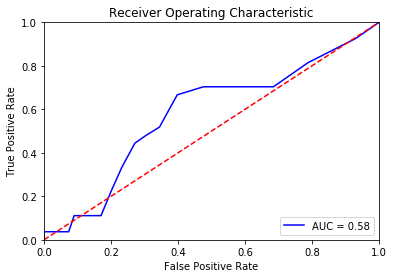

In [104]:
## Plot ROC Curve
# calculate the fpr and tpr for all thresholds of the classification
probs = rf_model.predict_proba(test_x)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


Randomforest model is overfitting the data 94% accuracy and AUC is 0.58

##### Lgistic Regression Model

In [99]:
logreg_model = LogisticRegression(class_weight='balanced',random_state=0) # {1:16}
logreg_model.fit(train_x,train_y)
pred = logreg_model.predict(test_x)
print('Accuracy of RandomForest model is:',accuracy_score(test_y,pred))
print()
print('Classification report:\n',classification_report(test_y,pred))

Accuracy of RandomForest model is: 0.8268398268398268

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90       435
           1       0.10      0.26      0.15        27

    accuracy                           0.83       462
   macro avg       0.53      0.56      0.53       462
weighted avg       0.90      0.83      0.86       462



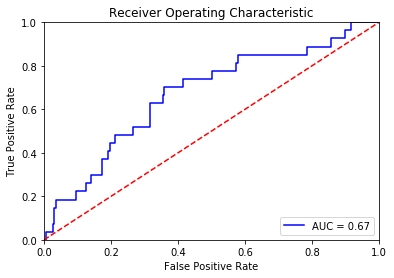

In [105]:
## Plot ROC Curve
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg_model.predict_proba(test_x)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

LogisticRegression model is overfitting the data 82% accuracy and AUC is 0.67

**Conclusion:<br> As the AUC, precision and recall values are very less - the models are failed to predict the positive classes correctly in comparison with negative classes**<br>
**Hence look for other methodologies to capture the patterns correctly**